<h1 align="center">Advanced Image Processing and Analysis</h1>
<h3 align="center">ECE 4438B/ECE 9022/ECE 9202B/BIOMED 9519B/BIOPHYS 9519B/CAMI 9519B</h3>
<h4 align="center"><a href="mailto:echen29@uwo.ca?subject=Day Day 28: Exercise"> Elvis Chen, PhD, LL</a></h4>
<h4 align="center">Day 28, April 09, 2019</h4>

### Improving Registration via Registration:  **Semi-Automatic Landmark Localization**

This notebook is intentionally missing code, an example of a <font color="red">homework</font> assignment using SimpleITK.

Localization of anatomical landmarks or fiducial markers in medical images is a common task, both for initializing intensity based registration between two images and for registration between the image space and physical space in computer assisted interventions.

In this notebook our goal is to rigidly register two images using manually localized point pairs. You will then improve the initial result by improving the point localization in the moving image via registration between each of the landmark regions in the fixed and moving images. 

### Manual Localization

* Advantages: identification, coarse localization, of the landmarks or fiducials is extremely <a href="https://en.wikipedia.org/wiki/Robust_statistics">robust</a>. Humans readily identify salient features in the presence of noise and under a variety of spatial transformations, including large deformations.
* Disadvantages: exhibits low <a href="https://en.wikipedia.org/wiki/Accuracy_and_precision">accuracy and precision</a>. 

### Automatic Localization 

* Advantages: highly precise, and with a good coarse localization it is also highly accurate.
* Disadvantages: prone to failure in the presence of noise and requires knowledge of the possible spatial transformations the landmark may undergo. 

### Semiautomatic Localization 
A Combination of manual and automatic components to obtain a robust (human contribution), accurate and precise (machine contribution) localization.  

In [1]:
# To use interactive plots (mouse clicks, zooming, panning) we use the nbagg back end. We want our graphs 
# to be embedded in the notebook, inline mode, this combination is defined by the magic "%matplotlib notebook".
%matplotlib notebook

import numpy as np
import SimpleITK as sitk
import registration_utilities as ru
%run update_path_to_download_script
from downloaddata import fetch_data as fdata
import gui

## Load Data

We will be working with the training data from the Retrospective Image Registration Evaluation (<a href="http://www.insight-journal.org/rire/">RIRE</a>) project. This data consists of a CT and MR of the same patient with a known rigid transformation between the two. We create a dense random point set in the CT image's coordinate system and transform it to the MR coordinate system. This set of points serves as our reference data for registration evaluation.

To ensure that your semi-automatic localization approach can deal with clinical data you should evaluate it using the data as is, and rotated. We test the extreme case where the data is rotated by 180$^o$ (boolean variable "rotate") so that in one scan the patient is in supine and in the other in prone position. 

We will start by loading our data and looking at the distances between corresponding points prior to registration, illustrates the spatial variability of the errors.

Fetching training_001_ct.mha
Fetching training_001_mr_T1.mha
Fetching ct_T1.standard


<IPython.core.display.Javascript object>


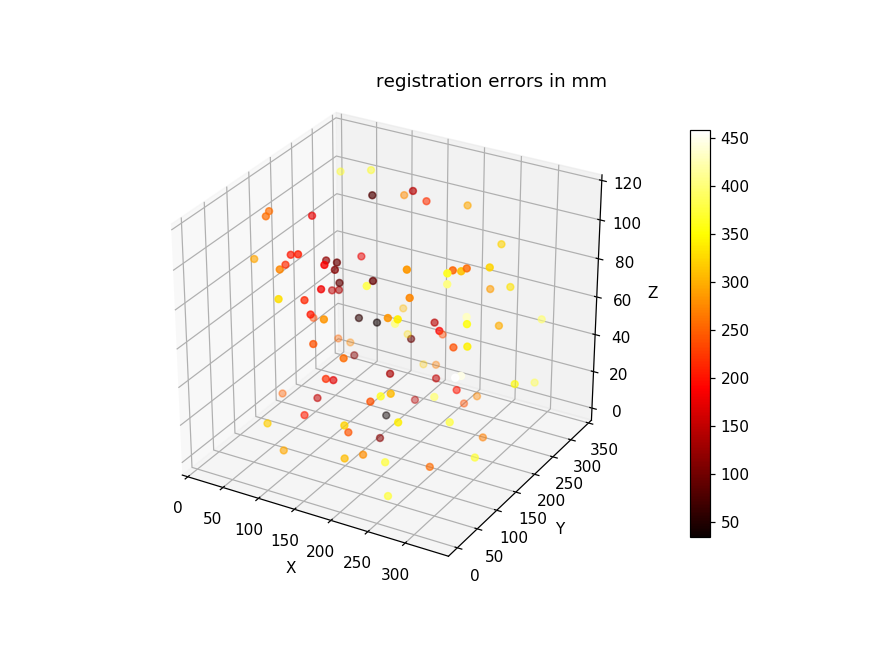

Before registration, errors (TRE) in millimeters, mean(std): 256.86(97.83), max: 458.24


In [2]:
fixed_image =  sitk.ReadImage(fdata("training_001_ct.mha"), sitk.sitkFloat32)
moving_image = sitk.ReadImage(fdata("training_001_mr_T1.mha"), sitk.sitkFloat32) 
fixed_fiducial_points, moving_fiducial_points = ru.load_RIRE_ground_truth(fdata("ct_T1.standard"))

# In the original data both images have the same orientation (patient in supine), the approach should also work when 
# images have different orientation. In the extreme they have a 180^o rotation between them.

rotate = True

if rotate:
    rotation_center = moving_image.TransformContinuousIndexToPhysicalPoint([(index-1)/2.0 for index in moving_image.GetSize()])    
    transform_moving = sitk.Euler3DTransform(rotation_center, 0, 0, np.pi, (0,0,0))
    
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(moving_image)
    resample.SetInterpolator(sitk.sitkLinear)    
    resample.SetTransform(transform_moving)
    moving_image = resample.Execute(moving_image)
    for i,p in enumerate(moving_fiducial_points):
        moving_fiducial_points[i] = transform_moving.TransformPoint(p)

        
# Compute the rigid transformation defined by the two point sets. Flatten the tuple lists 
# representing the points. The LandmarkBasedTransformInitializer expects the point coordinates 
# in one flat list [x1, y1, z1, x2, y2, z2...].
fixed_fiducial_points_flat = [c for p in fixed_fiducial_points for c in p]        
moving_fiducial_points_flat = [c for p in moving_fiducial_points for c in p]
reference_transform = sitk.LandmarkBasedTransformInitializer(sitk.VersorRigid3DTransform(), 
                                                             fixed_fiducial_points_flat, 
                                                             moving_fiducial_points_flat)

# Generate a reference dataset from the reference transformation 
# (corresponding points in the fixed and moving images).
fixed_points = ru.generate_random_pointset(image=fixed_image, num_points=100)
moving_points = [reference_transform.TransformPoint(p) for p in fixed_points]    

# Compute the TRE prior to registration.
pre_errors_mean, pre_errors_std, _, pre_errors_max, pre_errors = ru.registration_errors(sitk.Euler3DTransform(), fixed_points, moving_points, display_errors=True)
print('Before registration, errors (TRE) in millimeters, mean(std): {:.2f}({:.2f}), max: {:.2f}'.format(pre_errors_mean, pre_errors_std, pre_errors_max))        

## Manual Landmark Localization

We now localize N(>=3) landmarks in the two images. Note that you can zoom and pan the images, just remember to change the interaction mode from "edit" to "view". 

NOTE: In edit mode, the GUI will force you to enter corresponding points by disabling the option for consecutively localizing multiple (>2) points in the same image. In view mode, point localization is disabled which is useful for zooming/panning (in edit mode zooming/panning will also localize points due to the mouse button click).

<IPython.core.display.Javascript object>


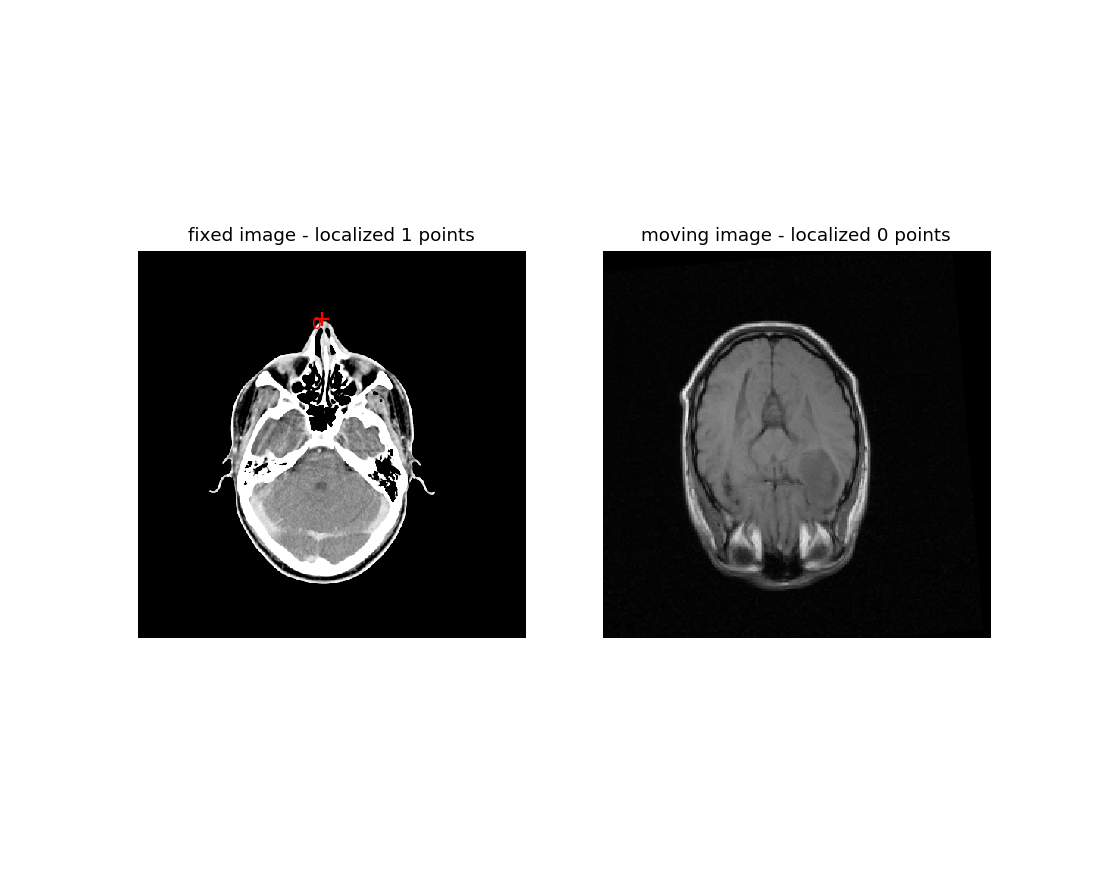

In [3]:
point_acquisition_interface = gui.RegistrationPointDataAquisition(fixed_image, moving_image, fixed_window_level=(215,50))

## Registration (manual landmark localization) 

Evaluate the quality of the manual localization by registering the two images, and then comparing the registration errors using the known reference data. m

In [4]:
#fixed_image_points, moving_image_points = point_acquisition_interface.get_points()
fixed_image_points = [(156.48434676356158, 201.92274575468412, 68.0), 
                      (194.25413436597393, 98.55771047484492, 32.0),
                      (128.94523819661913, 96.18284152323203, 32.0)]
moving_image_points = [(141.46826904042848, 156.97653126727528, 48.0),
                       (113.70102381552435, 251.76553994455645, 8.0),
                       (180.69457220262115, 251.76553994455645, 8.0)]

<IPython.core.display.Javascript object>


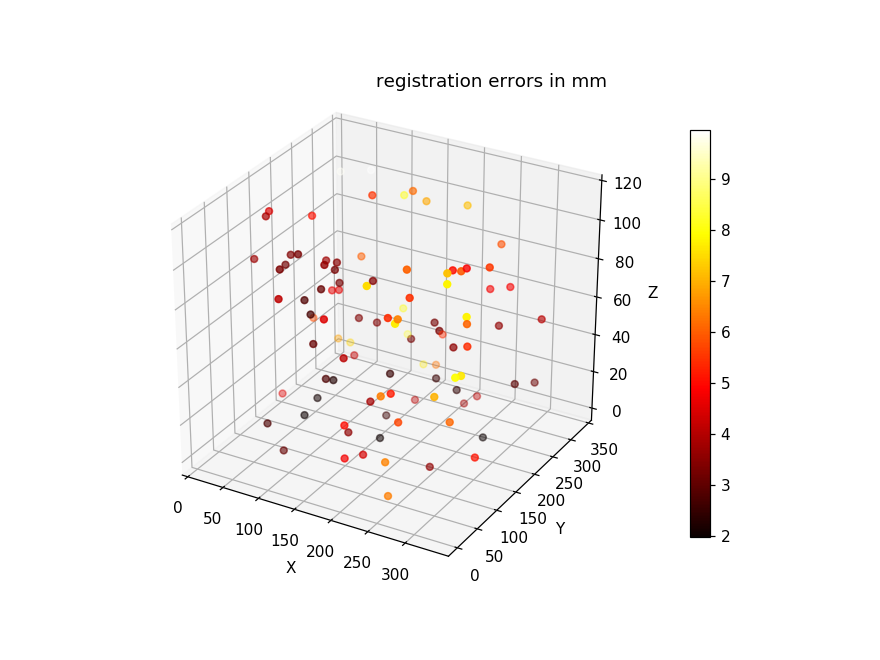

After registration (manual point localization), errors (TRE) in millimeters, mean(std): 4.82(1.84), max: 9.95


In [5]:
fixed_image_points_flat = [c for p in fixed_image_points for c in p]        
moving_image_points_flat = [c for p in moving_image_points for c in p]
manual_localized_transformation = sitk.VersorRigid3DTransform(sitk.LandmarkBasedTransformInitializer(sitk.VersorRigid3DTransform(), 
                                                                         fixed_image_points_flat, 
                                                                         moving_image_points_flat))

manual_errors_mean, manual_errors_std, manual_errors_min, manual_errors_max,_ = \
    ru.registration_errors(manual_localized_transformation,
                           fixed_points, 
                           moving_points, 
                           display_errors=True)
print('After registration (manual point localization), errors (TRE) in millimeters, mean(std): {:.2f}({:.2f}), max: {:.2f}'.format(manual_errors_mean, manual_errors_std, manual_errors_max))

We can also evaluate the registration qualitatively by using a linked cursor approach via the same GUI we used to localize corresponding points. This time the points will be added in pairs.

<IPython.core.display.Javascript object>


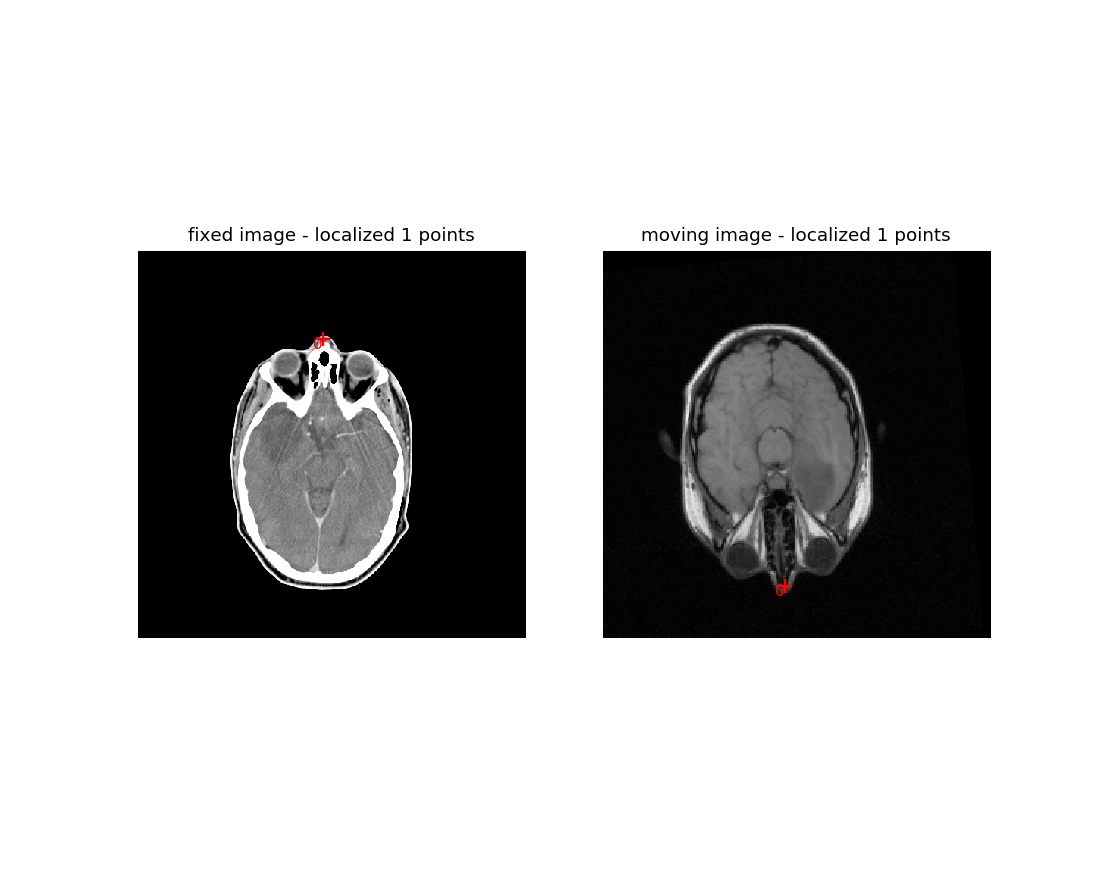

In [6]:
gui.RegistrationPointDataAquisition(fixed_image, moving_image, fixed_window_level=(215,50), known_transformation=manual_localized_transformation)

## <font color="red">Exercise:</font> semiautomatic landmark localization

You will now improve the localization of the fixed landmarks in the moving image using intensity based registration. This registration is performed independently for each landmark. 

The output of the following cell is expected to be a list of tuples (3D) called <b>updated_moving_image_points</b>.

Hint: You need to initialize the intensity based registration in a way that takes into account that the images may have a significant rotation between them (up to 180$^o$).

In [ ]:
updated_moving_image_points = moving_image_points

## Registration (semiautomatic landmark localization)

Evaluate the quality of the semiautomatic localization by registering the two images, and then comparing the registration errors using the known reference data. 

In [ ]:
updated_moving_image_points_flat = [c for p in updated_moving_image_points for c in p]        
semi_automatic_transform = sitk.VersorRigid3DTransform(sitk.LandmarkBasedTransformInitializer(sitk.VersorRigid3DTransform(), 
                                                                         fixed_image_points_flat, 
                                                                         updated_moving_image_points_flat))

semi_automatic_errors_mean, semi_automatic_errors_std, _, semi_automatic_errors_max,_ = ru.registration_errors(semi_automatic_transform,
                                                                                       fixed_points, 
                                                                                       moving_points, 
                                                                                       display_errors=True,
                                                                                       min_err=manual_errors_min,
                                                                                       max_err = manual_errors_max)
print('After registration (semiautomatic point localization), errors (TRE) in millimeters, mean(std): {:.2f}({:.2f}), max: {:.2f}'.format(semi_automatic_errors_mean, 
                                                                                                                                          semi_automatic_errors_std,
                                                                                                                                          semi_automatic_errors_max))

In [ ]:
gui.RegistrationPointDataAquisition(fixed_image, moving_image, fixed_window_level=(215,50), known_transformation=semi_automatic_transform)

## <font color="red">Answer</font> the following questions:

1. Is semiautomatic localization more precise than manual localization? Answer this question using Fiducial Registration Error. Repeat the manual and semiautomatic localizations multiple times and save the FREs to file. Plot the histograms of these errors (see matplotlib.pyplot.hist). Which method is more precise? Is this statistically significant? (see scipy.stats.ttest_rel).
  * Evaluate the variability, precision, of manual localization of point pairs using the reference transformation. The distribution of $\|p_{moving\_fiducial} - T(p_{fixed\_fiducial})\|$. 
  * Evaluate the variability, precision, of the semiautomatic localization of point pairs using the reference transformation. The distribution of $\|p_{moving\_updated\_fiducial} - T(p_{fixed\_fiducial})\|$.
   
2. Avoid the temptation to <a href="https://en.wikipedia.org/wiki/Overfitting">overfit</a>: When we only have pairs of manually localized points we may be tempted to use all of the point pairs and estimate a transformation that has more degrees of freedom. In our case, an affine transformation instead of a rigid one. To illustrate the problem with this approach you will manually localize four points in the two images. Estimate a rigid and an affine transformation using these points (change the transform type given as input to LandmarkBasedTransformInitializer).<br><br> 
Now compute the FRE associated with the two transformations and the TRE (using the fixed_points and moving_points data). Did the use of more degrees of freedom improve the registration results (smaller TREs)?